In [1]:
%%capture
# Please use python 3.7
import os
import numpy as np
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import pycatch22
from statsmodels.distributions.empirical_distribution import ECDF
from generate_motif import generate_prompt

### First we load the EEG data:

In [2]:
%%capture
from mne.datasets import eegbci
from mne.io import concatenate_raws, read_raw_edf
from mne.filter import filter_data
from scipy.ndimage import uniform_filter1d, sobel, prewitt, fourier_gaussian, fourier_shift
N = 100
runs = 1  # use only eye open data (left vs right)
# Get data and locate in to given path
allfiles = [eegbci.load_data(subject, runs, '../datasets/') for subject in range(N+1)[1:]]
# Read raw data files where each file contains a run
allraws = [[read_raw_edf(f, preload=True) for f in files] for files in allfiles]
# Combine all loaded runs
X_ = [np.array(concatenate_raws(raws).get_data()) for raws in allraws]
# X_ = [filter_data(X, 160, 1, 100) for X in X_]

### Calculate ranges of dimensionalities and autocorrelation timescales:

In [3]:
def extractglobal(X):
    pca = PCA()
    pca.fit(X)
    x = pca.components_[0]
    v = pca.explained_variance_ratio_[0]
    return x, v

### Then we extract a global signal for a single subject:

In [4]:
xs, pc = zip(*[extractglobal(X) for X in X_])

In [5]:
rc = [pycatch22.CO_f1ecac(list(x)) for x in xs]

Text(0.5, 1.0, 'Explained variances over subjects')

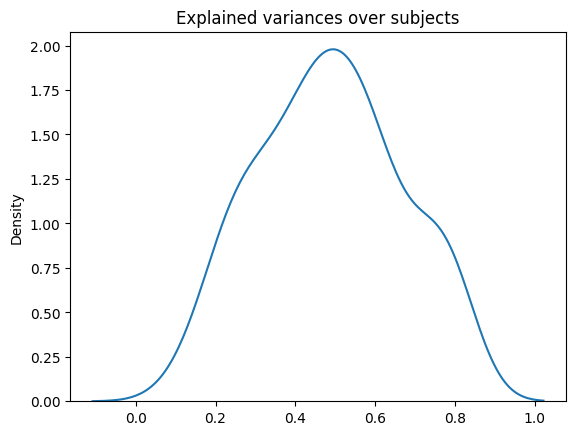

In [6]:
sns.kdeplot(pc)
plt.title('Explained variances over subjects')
# pca = PCA()
# pca.fit(X_[np.argmin(vs)])
# vs_ = pca.explained_variance_ratio_
# sns.lineplot(range(len(vs_)), vs_)

Text(0.5, 1.0, 'Timescales across subjects')

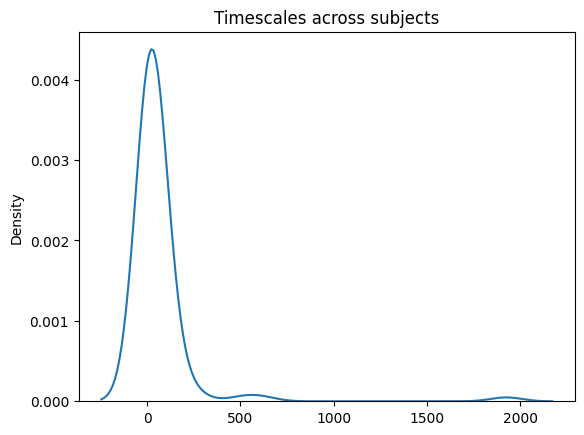

In [7]:
sns.kdeplot(rc)
plt.title('Timescales across subjects')

/home/brendan/.local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'PC = 0.56')

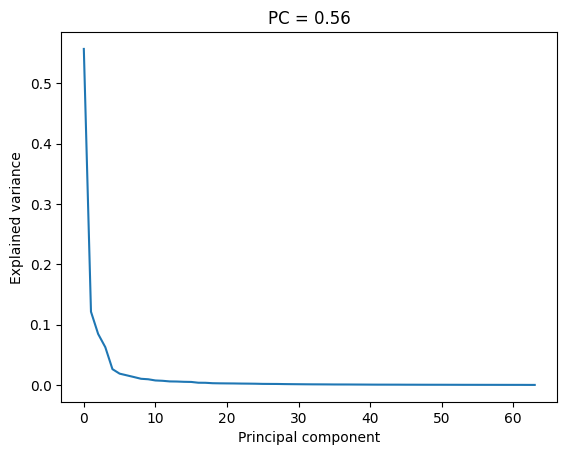

In [8]:
subj = 0
X = X_[subj]
pca = PCA()
pca.fit(X)
v = pca.explained_variance_ratio_
x = pca.components_[0]
sns.lineplot(range(len(v)), v)
plt.xlabel('Principal component')
plt.ylabel('Explained variance')
plt.title('PC = {:.2f}'.format(v[0]))

/home/brendan/.local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

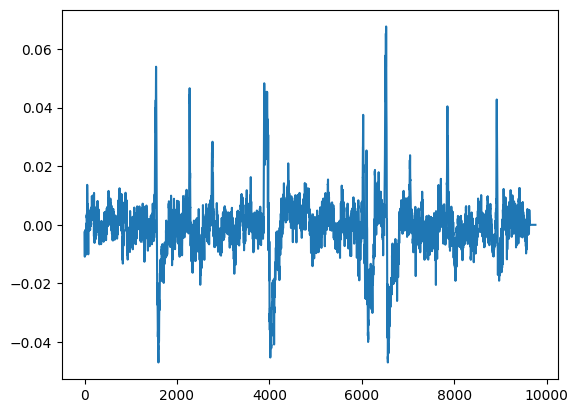

In [9]:
sns.lineplot(range(len(pca.components_[0])), pca.components_[0])

In [10]:
# Convert metrics to scores for a single subject using the cdf
pc = 1 - ECDF(pc)(v[0]) # One minus so that higher explained variance (lower dim.) means lower polyphonicity
rc = 1 - ECDF(rc)(pycatch22.CO_f1ecac(list(x))) # Longer timescales equal lower rhythmicity

### Generate a prompt from the global signal:

In [11]:
file_path = generate_prompt(x)

1
2
3
4
5
6
7
8
9
Notes:  [45, 60, 35, 37, 64, 50, 68, 38, 48, 47]
Velocities:  [106, 100, 100, 103, 111, 103, 93, 104, 100, 104]
Durations:  ([2, 1, 1, 1, 0.5, 2, 0.5, 2, 1, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Cumulative time:  [240, 360, 480, 600, 660, 900, 960, 1200, 1320, 1440]


In [12]:
import models
import os
import random
import pickle
from MuseMorphose import generate, midi2dataset
dset = midi2dataset(file_path)

[preparing data] now at #0


In [13]:
theme_file = generate(dset, 1, 1)
theme_file

[info] writing to ... /home/brendan/OneDrive/Masters/BrainHack2022/brainharmonic/MuseMorphose/generations/id3472060508_bar0_orig
[info] piece: 4127433179, bar: 0
[info] writing to ... /home/brendan/OneDrive/Masters/BrainHack2022/brainharmonic/MuseMorphose/generations/id3472060508_bar0_sample01_poly+1.0_rhym+1.0
[info] rhythm cls: tensor([1], device='cuda:0') | polyph_cls: tensor([1], device='cuda:0')
[info] generated 1 bars, #events = 22
[info] generated 2 bars, #events = 44
[info] generated 3 bars, #events = 69
[info] generated 4 bars, #events = 88
[info] generated 5 bars, #events = 113
[info] generated 6 bars, #events = 132
[info] generated 7 bars, #events = 154
[info] generated 8 bars, #events = 173
[info] generated 9 bars, #events = 195
[info] generated 10 bars, #events = 214
[info] generated 11 bars, #events = 239
[info] generated 12 bars, #events = 257
[info] generated 13 bars, #events = 279
[info] generated 14 bars, #events = 298
[info] generated 15 bars, #events = 323
[info] ge

'/home/brendan/OneDrive/Masters/BrainHack2022/brainharmonic/MuseMorphose/generations/id3472060508_bar0_sample01_poly+1.0_rhym+1.0.mid'

In [14]:
from Generate_multitrack import three_dominant_components, create_multitrack, transpose_song, add_delayed_track, add_skipped_notes_track
three_main_channels=three_dominant_components(X_[subj])
cs = three_main_channels[1]
# cs = [c - x for c in cs] # Subtract the global signal

In [15]:
from mido import MidiFile
theme_song = MidiFile(theme_file, clip=True)
theme_song.tracks = [theme_song.tracks[1]] # Remove the bogus track

In [16]:
song = create_multitrack(theme_song, x, cs[0], cs[1], cs[2],
                      transpose_up=True, transpose_down=True, add_delay=True,
                      add_skipped_notes=True, add_special_effect=False, change_track_velocity=False)
song.save('./test_song.mid')

MidiFile(type=1, ticks_per_beat=480, tracks=[
  MidiTrack([
    MetaMessage('track_name', name='Piano', time=0),
    Message('program_change', channel=0, program=0, time=0),
    Message('note_on', channel=0, note=35, velocity=64, time=0),
    Message('note_on', channel=0, note=60, velocity=64, time=0),
    Message('note_on', channel=0, note=42, velocity=64, time=480),
    Message('note_on', channel=0, note=51, velocity=64, time=720),
    Message('note_on', channel=0, note=35, velocity=0, time=120),
    Message('note_on', channel=0, note=60, velocity=0, time=0),
    Message('note_on', channel=0, note=68, velocity=64, time=120),
    Message('note_on', channel=0, note=51, velocity=0, time=120),
    Message('note_on', channel=0, note=42, velocity=0, time=240),
    Message('note_on', channel=0, note=42, velocity=52, time=120),
    Message('note_on', channel=0, note=70, velocity=70, time=0),
    Message('note_on', channel=0, note=42, velocity=0, time=480),
    Message('note_on', channel=0, n